In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
import seaborn as sns
import scipy.stats as stats

In [4]:
data = pd.read_csv("../outputs/summary_data.csv")
data = data.loc[
    ~data.isnull().any(axis=1),
]

labels = [
    "gs_score",
    "justice_gs_score_mean",
    "justice_gs_score_std",
    "justice_year_gs_score_mean",
    "justice_year_gs_score_std",
]
features = [
    "word_count",
    "duration",
    "pitch_log_diff_variance",
    "pitch_log_mean",
    "pitch_log_stdev",
    "pitch_log_2pct",
    "pitch_log_25pct",
    "pitch_log_50pct",
    "pitch_log_75pct",
    "pitch_log_98pct",
    "onset_count",
    "onset_str_mean",
    "onset_str_stddev",
    "onset_str_entropy",
    "onset_time_diff_mean",
    "onset_time_diff_stddev",
    "onset_time_diff_entropy",
    "word_rate",
    "onset_rate",
    "justice_word_count_mean",
    "justice_word_count_std",
    "justice_duration_mean",
    "justice_duration_std",
    "justice_pitch_log_diff_variance_mean",
    "justice_pitch_log_diff_variance_std",
    "justice_pitch_log_mean_mean",
    "justice_pitch_log_mean_std",
    "justice_pitch_log_stdev_mean",
    "justice_pitch_log_stdev_std",
    "justice_pitch_log_2pct_mean",
    "justice_pitch_log_2pct_std",
    "justice_pitch_log_25pct_mean",
    "justice_pitch_log_25pct_std",
    "justice_pitch_log_50pct_mean",
    "justice_pitch_log_50pct_std",
    "justice_pitch_log_75pct_mean",
    "justice_pitch_log_75pct_std",
    "justice_pitch_log_98pct_mean",
    "justice_pitch_log_98pct_std",
    "justice_onset_count_mean",
    "justice_onset_count_std",
    "justice_onset_str_mean_mean",
    "justice_onset_str_mean_std",
    "justice_onset_str_stddev_mean",
    "justice_onset_str_stddev_std",
    "justice_onset_str_entropy_mean",
    "justice_onset_str_entropy_std",
    "justice_onset_time_diff_mean_mean",
    "justice_onset_time_diff_mean_std",
    "justice_onset_time_diff_stddev_mean",
    "justice_onset_time_diff_stddev_std",
    "justice_onset_time_diff_entropy_mean",
    "justice_onset_time_diff_entropy_std",
    "justice_word_rate_mean",
    "justice_word_rate_std",
    "justice_onset_rate_mean",
    "justice_onset_rate_std",
    "justice_year_word_count_mean",
    "justice_year_word_count_std",
    "justice_year_duration_mean",
    "justice_year_duration_std",
    "justice_year_pitch_log_diff_variance_mean",
    "justice_year_pitch_log_diff_variance_std",
    "justice_year_pitch_log_mean_mean",
    "justice_year_pitch_log_mean_std",
    "justice_year_pitch_log_stdev_mean",
    "justice_year_pitch_log_stdev_std",
    "justice_year_pitch_log_2pct_mean",
    "justice_year_pitch_log_2pct_std",
    "justice_year_pitch_log_25pct_mean",
    "justice_year_pitch_log_25pct_std",
    "justice_year_pitch_log_50pct_mean",
    "justice_year_pitch_log_50pct_std",
    "justice_year_pitch_log_75pct_mean",
    "justice_year_pitch_log_75pct_std",
    "justice_year_pitch_log_98pct_mean",
    "justice_year_pitch_log_98pct_std",
    "justice_year_onset_count_mean",
    "justice_year_onset_count_std",
    "justice_year_onset_str_mean_mean",
    "justice_year_onset_str_mean_std",
    "justice_year_onset_str_stddev_mean",
    "justice_year_onset_str_stddev_std",
    "justice_year_onset_str_entropy_mean",
    "justice_year_onset_str_entropy_std",
    "justice_year_onset_time_diff_mean_mean",
    "justice_year_onset_time_diff_mean_std",
    "justice_year_onset_time_diff_stddev_mean",
    "justice_year_onset_time_diff_stddev_std",
    "justice_year_onset_time_diff_entropy_mean",
    "justice_year_onset_time_diff_entropy_std",
    "justice_year_word_rate_mean",
    "justice_year_word_rate_std",
    "justice_year_onset_rate_mean",
    "justice_year_onset_rate_std",
]

In [5]:
X = data[features]
y = data["gs_score"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=13
)
# y_weights = np.log1p(1/stats.norm.pdf(y_train, y_train.mean(), y_train.std()))

In [6]:
params = {
    "n_estimators": 200,
    "max_depth": 3,
    "min_samples_split": 64,
    "learning_rate": 0.1,
    "max_features": "sqrt",
    "loss": "squared_error",
}

reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(
    X_train,
    y_train,
)

mse = mean_squared_error(y_test, reg.predict(X_test))
r2 = r2_score(y_test, reg.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
print("The R-squared (R2) on test set: {:.4f}".format(r2))

The mean squared error (MSE) on test set: 0.2985
The R-squared (R2) on test set: 0.2847


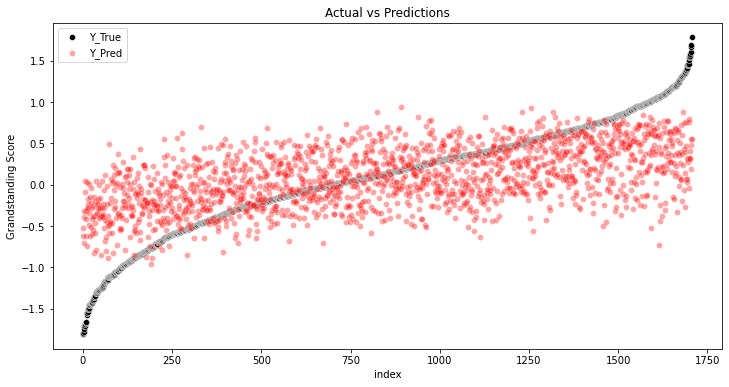

In [9]:
preds = reg.predict(X_test)
pred_df = pd.DataFrame(data={"y_true": y_test, "y_pred": preds})

pred_df = pred_df.sort_values("y_true").reset_index(drop=True)
pred_df = pred_df.reset_index(drop=False)

figure, ax = plt.subplots(ncols=1, figsize=(12, 6))
g = sns.scatterplot(
    x="index", y="y_true", data=pred_df, alpha=1, label="Y_True", color="k"
)
g = sns.scatterplot(
    x="index", y="y_pred", data=pred_df, alpha=0.35, label="Y_Pred", color="red"
)
plt.title("Actual vs Predictions")
plt.ylabel("Grandstanding Score")
plt.show()

In [10]:
stats.pearsonr(pred_df["y_true"], pred_df["y_pred"])

(0.5340357002606575, 1.791319287983597e-126)

In [28]:
data["gs_score"].describe()[["mean", "std"]]

mean    0.083191
std     0.660824
Name: gs_score, dtype: float64

In [12]:
# y_info = pd.DataFrame(zip(truths,preds), columns=['generated', 'predicted'])
print(
    pred_df.loc[(pred_df["y_pred"] >= -0.5) & (pred_df["y_pred"] <= 0.5)].shape[0]
    / (1.0 * pred_df.shape[0])
)
print(
    pred_df.loc[(pred_df["y_true"] >= -0.5) & (pred_df["y_true"] <= 0.5)].shape[0]
    / pred_df.shape[0]
)

0.8131224370240188
0.5383714118336262


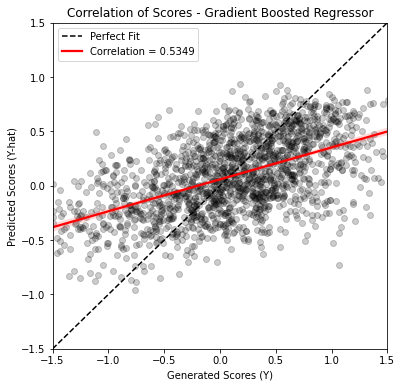

In [50]:
plt.figure(figsize=(6, 6))
plt.plot([-1.5, 1.5], [-1.5, 1.5], linestyle="--", color="k", label="Perfect Fit")

g = sns.regplot(
    x="y_true",
    y="y_pred",
    data=pred_df,
    scatter_kws={"color": "black", "alpha": 0.2},
    line_kws={"color": "red", "label": "Correlation = 0.5349"},
)

g.set(ylim=(-1.5, 1.5))
g.set(xlim=(-1.5, 1.5))
g.set(xlabel="Generated Scores (Y)")
g.set(ylabel="Predicted Scores (Y-hat)")
g.set(title=("Correlation of Scores - Gradient Boosted Regressor"))
g.legend()

C:\Users\yagne\.conda\envs\grandstanding\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(336.9714285714286, 0.5, 'Predicted Scores (Y-hat)')]

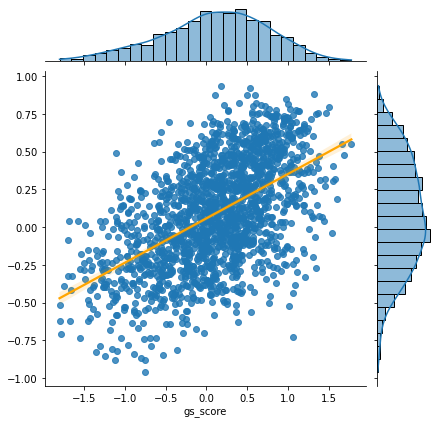

In [32]:
g = sns.jointplot(
    y_test,
    reg.predict(X_test),
    kind="reg",
    joint_kws={"line_kws": {"color": "orange", "label": "Correlation = 0.5349"}},
)
ax = plt.gca()
ax.set(xlabel="Generated Scores (Y)")
ax.set(ylabel="Predicted Scores (Y-hat)")

In [ ]:
param_grid = {
    "learning_rate": [0.001, 0.1, 1],
    "n_estimators": [200, 500, 1000],
    "min_samples_split": [4, 16, 64],
    "max_depth": [3, 5, None],
    "max_features": ["auto", "sqrt"],
}

grid = GridSearchCV(
    ensemble.GradientBoostingRegressor(),
    param_grid,
    scoring="neg_mean_squared_error",
    verbose=0,
    n_jobs=-1,
)
grid.fit(X_train, y_train)

In [6]:
print(grid.best_params_)
print(grid.best_score_)
# {'learning_rate': 0.1, 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_split': 64, 'n_estimators': 200}

{'learning_rate': 0.1, 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_split': 64, 'n_estimators': 200}
-0.3044898257467083


In [8]:
preds = grid.predict(X_test)
pred_df = pd.DataFrame(data={"y_true": y_test, "y_pred": preds})

pred_df = pred_df.sort_values("y_true").reset_index(drop=True)
pred_df = pred_df.reset_index(drop=False)

figure, ax = plt.subplots(ncols=1, figsize=(12, 6))
g = sns.scatterplot(
    x="index", y="y_true", data=pred_df, alpha=1, label="Y_True", color="k"
)
g = sns.scatterplot(
    x="index", y="y_pred", data=pred_df, alpha=0.35, label="Y_Pred", color="red"
)
plt.title("Actual vs Predictions")
plt.ylabel("Grandstanding Score")
plt.show()

NameError: name 'grid' is not defined

In [8]:
print(r2_score(y_test, preds))
print(mean_squared_error(y_test, preds))

0.2803725655209136
0.3003031067992053


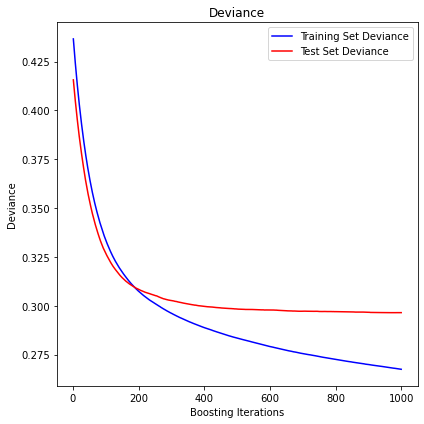

In [5]:
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(X_test)):
    test_score[i] = reg.loss_(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    reg.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
fig.tight_layout()
plt.show()

In [6]:
feat_imp = pd.DataFrame(
    list(zip(features, reg.feature_importances_)), columns=["feature", "importance"]
)
feat_imp = feat_imp.sort_values("importance", ascending=False)
feat_imp.loc[feat_imp["importance"] > 0]

,feature,importance
0,word_count,0.465085
17,word_rate,0.134013
75,justice_year_pitch_log_98pct_mean,0.060196
3,pitch_log_mean,0.030790
9,pitch_log_98pct,0.029203
...,...,...
50,justice_onset_time_diff_stddev_std,0.000105
20,justice_word_count_std,0.000079
69,justice_year_pitch_log_25pct_mean,0.000028
44,justice_onset_str_stddev_std,0.000016


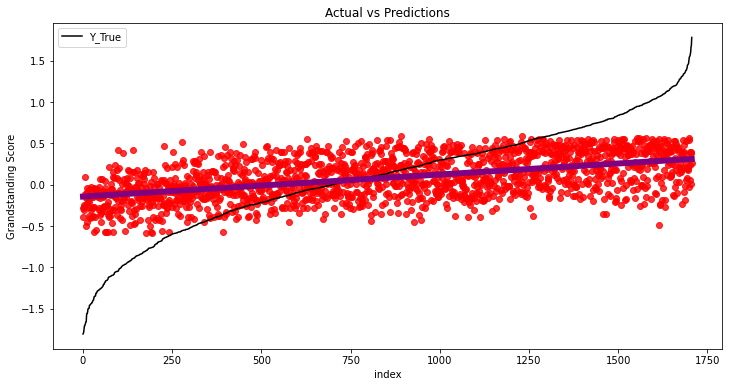

In [9]:
preds = reg.predict(X_test)
pred_df = pd.DataFrame(data={"y_true": y_test, "y_pred": preds})

pred_df = pred_df.sort_values("y_true").reset_index(drop=True)
pred_df = pred_df.reset_index(drop=False)

figure, ax = plt.subplots(ncols=1, figsize=(12, 6))
g = sns.lineplot(
    x="index", y="y_true", data=pred_df, alpha=1, label="Y_True", color="k"
)
g = sns.regplot(
    x="index",
    y="y_pred",
    data=pred_df,
    label="Y_Pred",
    color="red",
    line_kws={"color": "purple", "linewidth": 6, "label": "Learned Trend"},
)
plt.title("Actual vs Predictions")
plt.ylabel("Grandstanding Score")
plt.show()

In [11]:
from scipy.stats import linregress

slope, intercept, r, p, se = linregress(pred_df["y_true"], pred_df["y_pred"])
print(f"R-squared: {r**2:.6f}")

R-squared: 0.290198


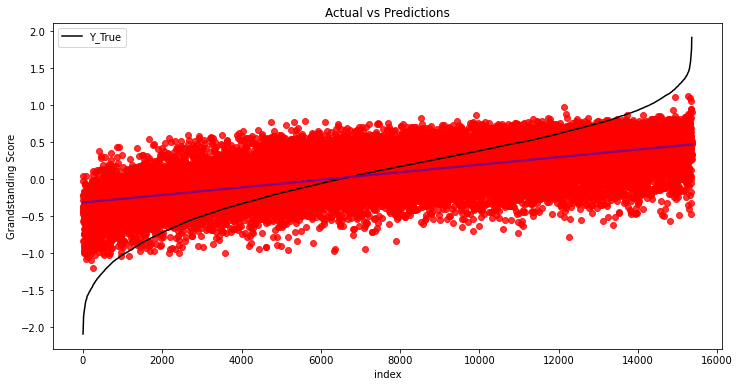

In [8]:
preds = reg.predict(X_train)
pred_df = pd.DataFrame(data={"y_true": y_train, "y_pred": preds})

pred_df = pred_df.sort_values("y_true").reset_index(drop=True)
pred_df = pred_df.reset_index(drop=False)

figure, ax = plt.subplots(ncols=1, figsize=(12, 6))
g = sns.lineplot(
    x="index", y="y_true", data=pred_df, alpha=1, label="Y_True", color="k"
)
g = sns.regplot(
    x="index",
    y="y_pred",
    data=pred_df,
    label="Y_Pred",
    color="red",
    line_kws={"color": "purple"},
)
plt.title("Actual vs Predictions")
plt.ylabel("Grandstanding Score")
plt.show()